# 0. Introduction of K2, AGN, and time series
## II. Comparison of FFT and Lomb-Scargle Periodograms

M. Gully-Santiago  
Summer 2019  
Kepler/K2 GO Office

This example is [ever-so-slightly-modified](https://github.com/dfm/celerite/issues/140) from the [PSD Normalization Tutorial](https://celerite.readthedocs.io/en/stable/_static/notebooks/normalization.ipynb) from the [celerite documentation](https://celerite.readthedocs.io) by Dan Foreman-Mackey.

In [1]:
#! wget 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

In [3]:
import celerite
from celerite import terms

/Users/obsidian/anaconda3/envs/probabilisticAGN/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


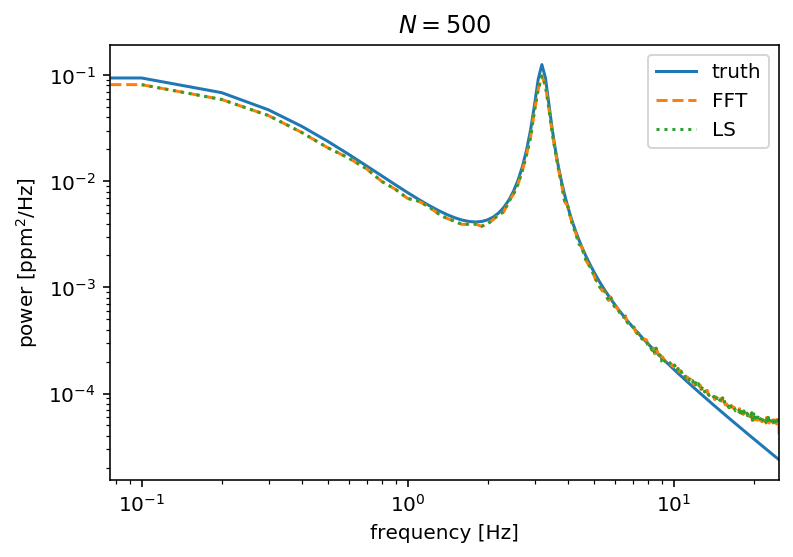

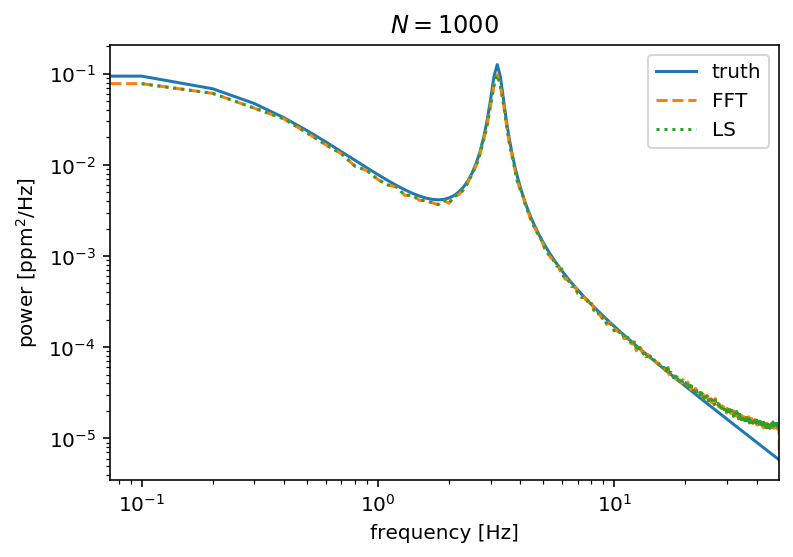

In [4]:
def simulate_and_compute_psds(N, K=1500):
    # Set up a simple celerite model
    kernel = terms.RealTerm(0.1, 0.5) + terms.ComplexTerm(0.5, 0.05, 3.0)
    gp = celerite.GP(kernel)

    # Simulate K datasets with N points
    t = np.linspace(0, 10, N)
    gp.compute(t)
    np.random.seed(42)
    y = gp.sample(size=K)

    # Compute the FFT based power spectrum estimates
    f = np.fft.rfftfreq(len(t), t[1] - t[0])
    fft = np.array(list(map(np.fft.rfft, y)))
    fft *= np.conj(fft)

    # >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
    power_fft = fft.real / N**2

    # Compute the LS based power spectrum estimates
    power_ls = []
    for y0 in y:
        model = LombScargle(t, y0)
        power_ls.append(model.power(f[1:-1], method="fast", normalization="psd"))
    power_ls = np.array(power_ls)

    # >>> To get the LS based PSD in the correct units, normalize by N <<<
    power_ls /= N

    # Compute the true power spectrum
    # NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
    power_true = kernel.get_psd(2*np.pi*f)

    # >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
    power_true /= (0.5 * (t[-1] - t[0])) # See the recent GitHub Issue on "PSD normalization bug"

    # Let's plot the estimates of the PSD
    plt.figure()
    plt.plot(f, power_true, label="truth")
    plt.plot(f, np.median(power_fft, axis=0), "--", label="FFT")
    plt.plot(f[1:-1], np.median(power_ls, axis=0), ":", label="LS")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(f.min(), f.max())
    plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
    plt.xlabel("frequency [Hz]")
    plt.title("$N = {0}$".format(N))
    plt.legend()

simulate_and_compute_psds(500)
simulate_and_compute_psds(1000)

You get the same answer whether you do FFT or Lomb-Scargle.  One difference is that Lomb-Scargle can handle missing data and the other one cannot.  We address missing data in the next notebook.